# Multi class image classification:

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


In [1]:
%%capture
!pip install smdebug
!pip install smdebug torch torchvision tqdm

In [2]:
import sagemaker
from sagemaker.debugger import (
    Rule,
    rule_configs, 
    ProfilerRule,
    DebuggerHookConfig,
    CollectionConfig,
    ProfilerConfig,
    FrameworkProfile
)
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot
import boto3
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs
from sagemaker.debugger import ProfilerConfig, FrameworkProfile
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts
from smdebug import modes
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import IPython
conn = boto3.client('s3')
role = get_execution_role()

[2022-06-01 08:15:56.394 ip-172-16-31-20:20949 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None


In [3]:
role = get_execution_role()

## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

In [4]:
%%capture
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip
!aws s3 cp dogImages s3://srs-udacity-aws-2022/project2/ --recursive

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [4]:
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.0001, 0.1),
    "eps": ContinuousParameter(1e-9, 1e-8),
    "weight_decay": ContinuousParameter(1e-3, 1e-1),
    "batch_size": CategoricalParameter([ 64, 128]),
    "epochs": CategoricalParameter([ 5, 10, 15, 20]),
}
objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test loss: ([0-9\\.]+)"}]

In [5]:
estimator = PyTorch(
    entry_point="hpo.py",
    base_job_name='pytorch_dog_hpo',
    role=role,
    framework_version="1.4.0",
    instance_count=1,
    instance_type='ml.p3.2xlarge', 
    py_version='py3'
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=1,
    objective_type=objective_type,
    early_stopping_type="Auto"
)

In [6]:
%%time
tuner.fit({"training": "s3://srs-udacity-aws-2022/project2/"})

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [7]:
best_estimator=tuner.best_estimator()
best_estimator.hyperparameters()


2022-06-01 09:37:30 Starting - Preparing the instances for training
2022-06-01 09:37:30 Downloading - Downloading input data
2022-06-01 09:37:30 Training - Training image download completed. Training in progress.
2022-06-01 09:37:30 Uploading - Uploading generated training model
2022-06-01 09:37:30 Completed - Training job completed


{'_tuning_objective_metric': '"average test loss"',
 'batch_size': '"128"',
 'epochs': '"20"',
 'eps': '7.111721669839231e-09',
 'lr': '0.000237052628202138',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch_dog_hpo-2022-06-01-08-16-04-420"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-628477620632/pytorch_dog_hpo-2022-06-01-08-16-04-420/source/sourcedir.tar.gz"',
 'weight_decay': '0.044323425684480625'}

In [8]:
best_hyperparameters={'batch_size': int(best_estimator.hyperparameters()['batch_size'].replace('"', "")),
                      'eps': best_estimator.hyperparameters()['eps'],
                      'lr': best_estimator.hyperparameters()['lr'],
                      'weight_decay': best_estimator.hyperparameters()['weight_decay'],}
best_hyperparameters

{'batch_size': 128,
 'eps': '7.111721669839231e-09',
 'lr': '0.000237052628202138',
 'weight_decay': '0.044323425684480625'}

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [9]:
rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

profiler_config = ProfilerConfig(system_monitor_interval_millis=500,
                                 framework_profile_params=FrameworkProfile(num_steps=10)
)

collection_configs=[CollectionConfig(name="CrossEntropyLoss_output_0",parameters={
    "include_regex": "CrossEntropyLoss_output_0", "train.save_interval": "10","eval.save_interval": "1"})]

debugger_config=DebuggerHookConfig( collection_configs=collection_configs )

In [10]:
%%time
estimator = PyTorch(
    entry_point="train_model.py",
    instance_count=1,
    instance_type="ml.p3.2xlarge",
    role=role,
    framework_version="1.4.0",
    py_version="py3",
    hyperparameters=best_hyperparameters,
    profiler_config=profiler_config, # include the profiler hook
    debugger_hook_config=debugger_config, # include the debugger hook
    rules=rules
)


estimator.fit({'training' : "s3://srs-udacity-aws-2022/project2/" },wait=True)

2022-06-01 09:42:15 Starting - Starting the training job...
2022-06-01 09:42:43 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
.........
2022-06-01 09:44:04 Downloading - Downloading input data.........
2022-06-01 09:45:44 Training - Downloading the training image......
2022-06-01 09:46:45 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-06-01 09:46:36,787 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2022-06-01 09:46:36,812 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-06-01 09:46:36,816 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-06-01 09:46:37,161 sagemaker-containers INFO     Module default

train loss: 570.0, acc: 19, best loss: 1000000.0
epoch time: 139.7886209487915
valid loss: 460.0, acc: 49, best loss: 460.0
epoch time: 170.96406030654907
Epoch: 2
train loss: 434.0, acc: 51, best loss: 460.0
epoch time: 85.34451651573181
valid loss: 308.0, acc: 70, best loss: 308.0
epoch time: 95.67098641395569
Testing Model
Test loss: 306.0
Test accuracy: 69.0
Saving Model
2022-06-01 09:51:23,979 sagemaker-containers INFO     Reporting training SUCCESS

2022-06-01 09:51:50 Uploading - Uploading generated training model
2022-06-01 09:51:50 Completed - Training job completed
Training seconds: 473
Billable seconds: 473
CPU times: user 1.41 s, sys: 0 ns, total: 1.41 s
Wall time: 9min 50s


In [11]:
job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)
print(f"Jobname: {job_name}")
print(f"Client: {client}")
print(f"Description: {description}")

Jobname: pytorch-training-2022-06-01-09-42-14-560
Client: <botocore.client.SageMaker object at 0x7fdde12657d0>
Description: {'TrainingJobName': 'pytorch-training-2022-06-01-09-42-14-560', 'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:628477620632:training-job/pytorch-training-2022-06-01-09-42-14-560', 'ModelArtifacts': {'S3ModelArtifacts': 's3://sagemaker-us-east-1-628477620632/pytorch-training-2022-06-01-09-42-14-560/output/model.tar.gz'}, 'TrainingJobStatus': 'Completed', 'SecondaryStatus': 'Completed', 'HyperParameters': {'batch_size': '128', 'eps': '"7.111721669839231e-09"', 'lr': '"0.000237052628202138"', 'sagemaker_container_log_level': '20', 'sagemaker_job_name': '"pytorch-training-2022-06-01-09-42-14-560"', 'sagemaker_program': '"train_model.py"', 'sagemaker_region': '"us-east-1"', 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-628477620632/pytorch-training-2022-06-01-09-42-14-560/source/sourcedir.tar.gz"', 'weight_decay': '"0.044323425684480625"'}, 'AlgorithmSpecifi

In [12]:
trial = create_trial(estimator.latest_job_debugger_artifacts_path())

[2022-06-01 09:52:05.235 ip-172-16-31-20:20949 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-628477620632/pytorch-training-2022-06-01-09-42-14-560/debug-output


[2022-06-01 09:52:06.337 ip-172-16-31-20:20949 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2022-06-01 09:52:07.355 ip-172-16-31-20:20949 INFO trial.py:210] Loaded all steps
loaded trining data
loaded validation data
Completed TRAIN plot
Completed EVAL plot


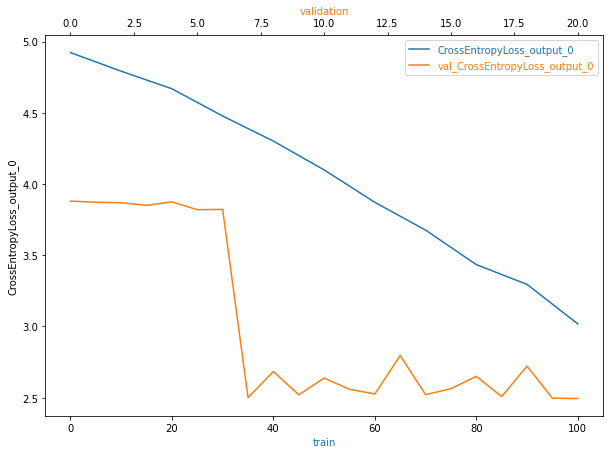

In [13]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

#plot tensor utility functions for plotting tensors
def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded trining data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded validation data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("train")
    par.set_xlabel("validation")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("Completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("Completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)
    plt.show()
plot_tensor(trial, "CrossEntropyLoss_output_0")

In [14]:
estimator.latest_training_job.job_name

'pytorch-training-2022-06-01-09-42-14-560'

In [15]:
estimator.latest_training_job.job_name

'pytorch-training-2022-06-01-09-42-14-560'

In [17]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
rule_output_path

's3://sagemaker-us-east-1-628477620632/pytorch-training-2022-06-01-09-42-14-560/rule-output'

In [18]:
! aws s3 ls {rule_output_path} --recursive

2022-06-01 09:51:43     335946 pytorch-training-2022-06-01-09-42-14-560/rule-output/ProfilerReport/profiler-output/profiler-report.html
2022-06-01 09:51:43     178337 pytorch-training-2022-06-01-09-42-14-560/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2022-06-01 09:51:39        191 pytorch-training-2022-06-01-09-42-14-560/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2022-06-01 09:51:39      17576 pytorch-training-2022-06-01-09-42-14-560/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2022-06-01 09:51:39        126 pytorch-training-2022-06-01-09-42-14-560/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2022-06-01 09:51:39        129 pytorch-training-2022-06-01-09-42-14-560/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2022-06-01 09:51:39       7208 pytorch-training-2022-06-01-09-42-14-560/rule-output/ProfilerReport/profiler-output/profiler-re

In [19]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-628477620632/pytorch-training-2022-06-01-09-42-14-560/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json to ProfilerReport/profiler-output/profiler-reports/Dataloader.json
download: s3://sagemaker-us-east-1-628477620632/pytorch-training-2022-06-01-09-42-14-560/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json to ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
download: s3://sagemaker-us-east-1-628477620632/pytorch-training-2022-06-01-09-42-14-560/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json to ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
download: s3://sagemaker-us-east-1-628477620632/pytorch-training-2022-06-01-09-42-14-560/rule-output/ProfilerReport/profiler-output/profiler-report.html to ProfilerReport/profiler-output/profiler-report.html
download: s3://sagemaker-us-east-1-628477620632/pytorch-training-2022-06-01-

- We might see that the validation error increases while the training error decreases. In this case, we should stop since we are overfitting.

- We might see that the training error is not decreasing, which can be due to using of wrong architecture, to small or big learning rate, or etc. 


## Model Deploying

In [53]:
import sagemaker
from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor

from PIL import Image
import io
import requests
import numpy as np

In [17]:
best_hyperparameters = {'batch_size': 64,
                         'eps': '9.035130055020735e-09',
                         'lr': '0.00010642806589020997',
                         'weight_decay': '0.005363793838194886'}

In [50]:
%%time
estimator = PyTorch(
    entry_point="hpo.py",
    instance_count=1,
    instance_type="ml.p3.2xlarge",
    role=role,
    framework_version="1.8",
    py_version="py36",
    hyperparameters=best_hyperparameters,
)


estimator.fit({'training' : "s3://srs-udacity-aws-2022/project2/" },wait=True)
model_location=estimator.model_data

2022-05-31 11:32:23 Starting - Starting the training job...
2022-05-31 11:32:51 Starting - Preparing the instances for trainingProfilerReport-1653996743: InProgress
.........
2022-05-31 11:34:17 Downloading - Downloading input data.........
2022-05-31 11:35:50 Training - Downloading the training image.....................
2022-05-31 11:39:14 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-05-31 11:39:17,051 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-05-31 11:39:17,073 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-05-31 11:39:17,080 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-05-31 11:39:17,884 sagemaker-training-toolkit INFO     Invoking user script
Training Env:
{
    "additional_framework_parameters": {},
    "cha

train loss: 238.0, acc: 23, best loss: 242.0
epoch time: 84.2699282169342
valid loss: 181.0, acc: 31, best loss: 181.0
epoch time: 94.73107051849365
Testing Model
Test loss: 180.0
Test accuracy: 31.0
Saving Model
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
#015  0%|          | 0.00/97.8M [00:00<?, ?B/s]#015 12%|█▏        | 12.2M/97.8M [00:00<00:00, 128MB/s]#015 26%|██▋       | 25.8M/97.8M [00:00<00:00, 137MB/s]#015 40%|███▉      | 38.9M/97.8M [00:00<00:00, 132MB/s]#015 53%|█████▎    | 51.6M/97.8M [00:00<00:00, 133MB/s]#015 67%|██████▋   | 65.1M/97.8M [00:00<00:00, 135MB/s]#015 80%|███████▉  | 78.0M/97.8M [00:00<00:00, 135MB/s]#015 94%|█████████▍| 92.4M/97.8M [00:00<00:00, 140MB/s]#015100%|██████████| 97.8M/97.8M [00:00<00:00, 138MB/s]
INFO:__main__:train loss: 291.0, acc: 9, best loss: 1000000.0
INFO:__main__:epoch time: 101.18146634101868
INFO:__main__:valid loss: 242.0, acc: 20, best loss: 242.0


In [57]:
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()


class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

In [58]:
pytorch_model = PyTorchModel(model_data=model_location, 
                             role=role, 
                             entry_point='infernce.py',
                             py_version='py36',
                             framework_version='1.8',
                             predictor_cls=ImagePredictor)

predictor = pytorch_model.deploy(initial_instance_count=1, 
                                 instance_type='ml.m5.large')


------!

In [80]:
with open("./dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg", "rb") as image:
  f = image.read()
  b = bytearray(f)
    
response=predictor.predict(b, initial_args={"ContentType": "image/jpeg"})
np.argmax(response, 1)

array([0])